In [1]:
#torch 
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms,datasets
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights


#images
from PIL import Image, ImageOps
import cv2
import albumentations as A

#math/data
import numpy as np
from matplotlib import pyplot as plt
import sklearn.model_selection as skm
import wider_face_dataset as wider
#misc
import os
from tqdm import tqdm
import json


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations


# Data Preperation 

The collected dataset is really tiny and not all that diverse, so we're going to apply some transforms on the data to flesh out our dataset with more diverse inputs

In [2]:
#these could be played around with all day, there likely isn't some optimal combination of transforms, as long as the images are altered
transform_data_expansion = A.Compose([
    A.Resize(height=250,width=200,p=1),
    
    A.HorizontalFlip(p=0.4),
    A.RandomBrightnessContrast(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.RGBShift(p=0.8),
    A.RandomFog(alpha_coef = .2,p=0.5)
    
], bbox_params=A.BboxParams(format="albumentations", label_fields=['class_labels']))

#the wider dataset is massive, the only transformation we will be doing is changing the size of each image
transform_fix_wider = A.Compose([
    A.Resize(height=250,width=200,p=1),
], bbox_params=A.BboxParams(format="albumentations", label_fields=['class_labels']))


convert_to_tensor = transforms.Compose([transforms.ToTensor()])


In [3]:
#this function will help us with our dataloader later, so our batch sizes actually return targets in a format that our model likes
def collate_fn(batch):
    return tuple(zip(*batch))

In [4]:
#we'll go ahead and create our data loader and dataset classes up here

class ImageDataset(datasets.VisionDataset):
    def __init__(self, image_list, label_list):
        self.image_list = image_list
        self.label_list = label_list

    def __getitem__(self, id):
        request_image = self.image_list[id]
        image_label = self.label_list[id]
        
        target = {'boxes':None , 'labels': None}

        request_image = convert_to_tensor(request_image).cuda() if torch.cuda.is_available() else convert_to_tensor(request_image)

        target['boxes'] = torch.Tensor([box for box in image_label[0]]).cuda() if torch.cuda.is_available() else torch.Tensor([box for box in image_label[0]])
        target['labels'] = torch.cuda.LongTensor([label for label in image_label[1]]) if torch.cuda.is_available() else torch.LongTensor([label for label in image_label[1]])



        return request_image,target

    def __len__(self):
        return len(self.image_list)

The following code block transforms the images from the input directory and turns them into tensor objects, which are then stored in a list of Numpy arrays

In [5]:
def display_img_with_box(img : list, bboxes : list) -> None:

    cv2.rectangle(img,
              tuple(np.array(bboxes[:2]).astype(int)),
              tuple(np.array(bboxes[2:]).astype(int)),color=(255,1,1),thickness=1)
            
    plt.imshow(img, origin="lower")  

In [6]:
#function takes a path to a set of images and converts them into numpy arrays, then it returns a list containing each of those images
def fetch_pics(path: str) -> list:
    
    input_directory = os.fsencode(path)


    images_as_npA = []

    for image in os.listdir(input_directory):

        img = Image.open(path + "\\" + os.fsdecode(image))
        #new_tensor = convert_to_tensor(img)
        images_as_npA.append(np.array(ImageOps.exif_transpose(img)))

    return images_as_npA

#dedicated transformation function, so we can easily process images containing different classes, it would have to be changed if we were to introduce multiple classes
#Bbox_Labels is set to all zero by default to easily handle casses in which the scene is devoid of classes
#transformed data is a list that will get new data appended to it as the function runs
#data contains all of our numpy array images, type is what the image classifier contains, again, would need to be different if we were to multiclass
#multiplicity determines how many times each data point will be transformed into a new image
def transform_and_expand(transformed_data : list, data : list, type: str, Bbox_Labels : list = [],multiplicity : int = 1):

    #inevitably, this will take a very long time, as this loop is o(n) (multiplied by 30. But its constant, who cares!)
    for i in range(len(data)):
        
        #get the bounding box points for the image we are about to transform
        bounding_box_data =[Bbox_Labels[i][0][0],
                            Bbox_Labels[i][0][1],
                            Bbox_Labels[i][1][0],
                            Bbox_Labels[i][1][1]]
        #normalize the points based on the dimensions of the image
        image_shape = data[i].shape

        for z in range(multiplicity):
            copy_bounding_box = list(np.divide(bounding_box_data,[image_shape[1],image_shape[0],image_shape[1],image_shape[0]]))
            #we only need to append the retruned result, because the return value is a dictionary containg the transformed image, classes, and points as it's values
            transformed_data.append(transform_data_expansion(image = data[i], bboxes=[copy_bounding_box],class_labels = [type]))
   
        

# Get Data

First, we're going to get the labels

In [7]:
#TODO we may want to identify things that arent just me for less narcasistic purposes. So we should rewrite this to store the classes corresponding to each data point as well
label_directory = os.fsencode("Liam_Dataset\Liam_Labels")

Liam_Bbox_Labels = []

for json_f in os.listdir(label_directory):
    json_file = open("Liam_Dataset\Liam_Labels\\" + os.fsdecode(json_f))
    Liam_Bbox_Labels.append(json.load(json_file)['shapes'][0]['points'])
    json_file.close()


In [8]:

#set image path
Me_Inputs_Path = "Liam_Dataset\Liam_Input"

#save images as an array of numpy arrays
Liam_np_Array = fetch_pics(Me_Inputs_Path)


#list of our transformed input
transformed_data_Liam = []

#transform the data
transform_and_expand(transformed_data_Liam,data=Liam_np_Array,type=2,Bbox_Labels=Liam_Bbox_Labels,multiplicity=30)

#de-normalize the data so our model doesn't double normalize it
for box in transformed_data_Liam:
    #tuples are immutable, so we're gonna dig under that wall and cast it to a list
    box['bboxes'][0] = list(box['bboxes'][0])

    temp = box['bboxes'][0]

    box['bboxes'][0][0] = 200 * temp[0]
    box['bboxes'][0][1] = 250 * temp[1]
    box['bboxes'][0][2] = 200 * temp[2]
    box['bboxes'][0][3] = 250 * temp[3]
    
    #box['bboxes'][0] = tuple(box['bboxes'][0])


print(len(transformed_data_Liam))

2520


# Wider Dataset

Originally I trained this on just my face, but that taught the model that all faces must be my face. This is obviously too biased and ego inflating, so I am also going to show it a lot of random faces. Just so it can learn when something is absolutely not my face

Dropped Images: 2
Total WIDER Images:  2574


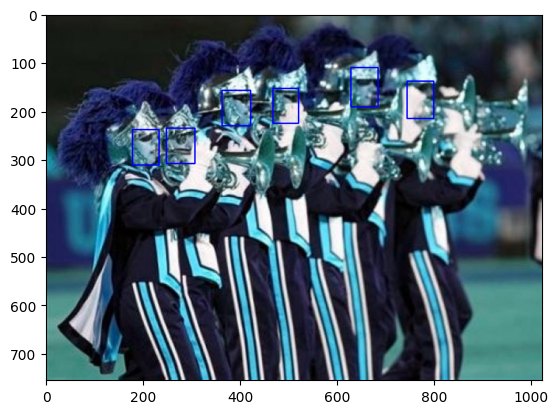

In [9]:
wider_image_set_path = "wider_train"
wider_label_path = "wider_face_split/wider_face_train.mat"

wider_Set = wider.WIDERFACEDataset(wider_image_set_path,wider_label_path)

wider_image_label_data = []

for x in range(int(wider_Set.__len__()/5)):

    wider_image_label_data.append(wider_Set.get_example(x))



ex = wider_Set.get_example(10)

for x in ex[1]:
    cv2.rectangle(ex[0],
                tuple(np.array(x[:2]).astype(int)),
                tuple(np.array(x[2:]).astype(int)),
                color = (0,0,255),thickness=2)



#using matplot here becauses cv2 causes crashes in the python enviorment, this will make the picture appear blue because matplot reads the color channels in a different order, but they are unaltered
plt.imshow(ex[0])
wider_transformed = []
dropped = 0

for i in range(len(wider_image_label_data)):
    
    #we have to normalize the bounding box points before we send them through the transformer
    image_shape = wider_image_label_data[i][0].shape
    normalized_boxes = []

    for box in wider_image_label_data[i][1]:
        box = list(np.divide(box,[image_shape[1],image_shape[0],image_shape[1],image_shape[0]]))
        normalized_boxes.append(box)

    try:
        wider_transformed.append(transform_fix_wider(image = wider_image_label_data[i][0],bboxes = normalized_boxes, class_labels=list(wider_image_label_data[i][2])))

    #if there is an error, we'll just drop the datapoint
    except Exception:
        dropped+=1
        continue

print(f'Dropped Images: {dropped}')


#now, we need to un-normalize the data we passed, because our model will try to normalize it again later. There is probably a more optimal way to do this, but its not really critical that this scales well
for data_point in wider_transformed:
    for box in data_point['bboxes']:
        box = list(box)
        temp = box
        box[0] = 200 * temp[0]
        box[1] = 250 * temp[1]
        box[2] = 200 * temp[2]
        box[3] = 250 * temp[3]

print("Total WIDER Images: ", len(wider_transformed))


# Check and Combine Data

[37.16872133881245, 35.24767732713951, 133.64897861949856, 151.93965517241378]


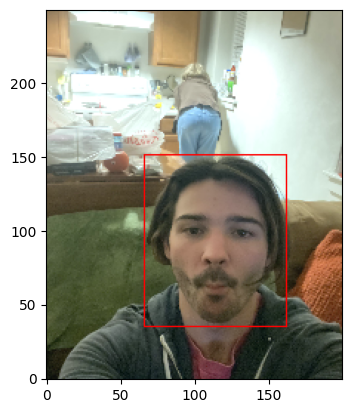

In [10]:
cv2.rectangle(transformed_data_Liam[2]['image'],
              tuple(np.array(transformed_data_Liam[2]['bboxes'][0][:2]).astype(int)),
              tuple(np.array(transformed_data_Liam[2]['bboxes'][0][2:]).astype(int)),color=(255,1,1),thickness=1)
            
plt.imshow(transformed_data_Liam[2]['image'], origin="lower")  





print(transformed_data_Liam[0]['bboxes'][0])

#combining labels
class_1_bboxes = [[data['bboxes'], data['class_labels']] for data in transformed_data_Liam]
class_0_bboxes = [[data['bboxes'],data['class_labels']] for data in wider_transformed]



#print(class_0_bboxes[0])

class_1_bboxes[0:0] = class_0_bboxes



#combining image sets
class_1_images = [data['image'] for data in transformed_data_Liam]
class_0_images = [data['image'] for data in wider_transformed]

class_1_images[0:0] = class_0_images


# Data Split!

It sounds counter intutive, because we just joined the data, but now we need to actually split the data into train, test, and validation data sets

3056
2038


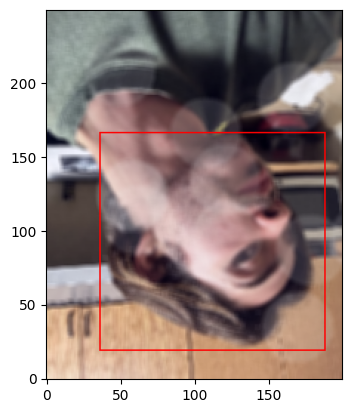

In [33]:



X_train, X_test, y_train, y_test = skm.train_test_split(class_1_images,class_1_bboxes,test_size=0.4)

test = 0



cv2.rectangle(X_train[test],
              tuple(np.array(y_train[test][0][0][:2]).astype(int)),
              tuple(np.array(y_train[test][0][0][2:]).astype(int)),color=(255,1,1),thickness=1)
            
plt.imshow(X_train[test], origin="lower") 



#now that we've confirmed our data hasn't been altered in an unintentional manner, we can place everything in a dataloader
Train_Dataset = ImageDataset(X_train,y_train)
Test_Dataset = ImageDataset(X_test, y_test)

#put our datasets into dataloaders
#I am almost certaintly doing something wrong, as setting the batch size to anything besides 1 (ex: 4), the loader returns a dictionary of lists instead of the other way around:
#TODO fix that issue
train_Dataloader = DataLoader(Train_Dataset,batch_size=10,shuffle=False,collate_fn=collate_fn)
test_Dataloader = DataLoader(Test_Dataset,batch_size=1,shuffle=False,collate_fn=collate_fn)


x,y = Train_Dataset.__getitem__(0)

print(Train_Dataset.__len__())
print(Test_Dataset.__len__())



# Model Creation

In [12]:
#here we're using a pretrained model to teach our model what my face looks like
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

model.roi_heads.box_predictor = FastRCNNPredictor(in_channels= model.roi_heads.box_predictor.cls_score.in_features, num_classes=3)
#determine whether we can train the model on our gpu or not
training_device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(training_device)

model.to(training_device)

cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Training

This is rough

In [13]:

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,lr = 0.05)


num_epochs = 10
loss = 0

all_loss = []

model.train()
for epoch in range(num_epochs):
    for data,target in train_Dataloader:
        loss = model(data,targets=target)
            
        losses = sum(loss for loss in loss.values())


        optimizer.zero_grad()
        losses.backward()
        all_loss.append(losses.item())
        optimizer.step()


    print(f"Epoch: {epoch} loss: {all_loss[-1]}")


Epoch: 0 loss: 0.10364259034395218
Epoch: 1 loss: 0.11429421603679657
Epoch: 2 loss: 0.10916632413864136
Epoch: 3 loss: 0.055904604494571686
Epoch: 4 loss: 0.07961234450340271
Epoch: 5 loss: 0.05414018779993057
Epoch: 6 loss: 0.059198684990406036
Epoch: 7 loss: 0.07003132998943329
Epoch: 8 loss: 0.04848535358905792
Epoch: 9 loss: 0.08761899173259735


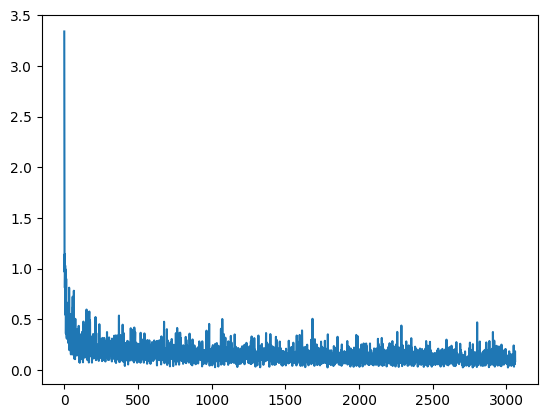

In [19]:
plt.plot(range(train_Dataloader.__len__()*num_epochs),all_loss)
plt.show()

In [36]:
model.eval()

model.to(training_device)
result_list = []

for x,y in test_Dataloader:
    with torch.no_grad():
        prediction = model(x,y)

        result_list.append(prediction)

print(result_list[-1])




[{'boxes': tensor([[7.7756e-01, 3.7208e-01, 8.5503e-01, 4.9598e-01],
        [1.8473e-01, 3.4713e-01, 2.4449e-01, 4.6061e-01],
        [7.1693e-01, 4.5792e-01, 7.8881e-01, 5.8283e-01],
        [2.6398e-01, 4.4532e-01, 3.2086e-01, 5.5372e-01],
        [8.6894e-01, 5.4682e-01, 9.3392e-01, 6.6078e-01],
        [2.5829e-01, 3.7759e-01, 3.1358e-01, 4.8986e-01],
        [2.6735e-01, 4.0465e-01, 3.2490e-01, 5.2283e-01],
        [2.5961e-01, 3.4623e-01, 3.0752e-01, 4.4070e-01],
        [2.8196e-01, 4.5294e-01, 3.4250e-01, 5.6974e-01],
        [2.7612e-01, 3.6976e-01, 3.3985e-01, 4.8990e-01],
        [6.6258e-01, 3.9525e-01, 7.2546e-01, 5.1451e-01],
        [2.8561e-01, 5.0771e-01, 3.4192e-01, 6.1572e-01],
        [2.9429e-01, 3.1797e-01, 3.5590e-01, 4.3572e-01],
        [7.1239e-01, 5.5382e-01, 7.8033e-01, 6.7406e-01],
        [3.3619e-01, 4.5288e-01, 3.9136e-01, 5.5900e-01],
        [3.4222e-01, 3.4944e-01, 3.9893e-01, 4.5798e-01],
        [3.5416e-01, 4.4030e-01, 4.0592e-01, 5.4287e-01],
   

tensor([[0.3004, 0.4356, 0.3862, 0.5991],
        [0.3530, 0.3984, 0.4393, 0.5645],
        [0.3212, 0.3702, 0.3914, 0.5059],
        [0.3904, 0.4161, 0.4914, 0.5907],
        [0.4214, 0.3809, 0.4933, 0.5215],
        [0.6783, 0.3342, 0.7532, 0.4622],
        [0.3845, 0.4776, 0.4652, 0.6464],
        [0.3712, 0.3170, 0.4528, 0.4830],
        [0.5306, 0.3620, 0.6240, 0.5315],
        [0.4637, 0.4311, 0.5334, 0.5677],
        [0.2933, 0.3184, 0.3602, 0.4556],
        [0.4893, 0.3364, 0.5514, 0.4623],
        [0.8220, 0.2838, 0.8835, 0.4017],
        [0.5797, 0.3593, 0.6538, 0.5076],
        [0.6139, 0.3963, 0.6892, 0.5239],
        [0.7584, 0.2699, 0.8303, 0.3947],
        [0.6505, 0.3043, 0.7323, 0.4429],
        [0.5301, 0.3096, 0.5947, 0.4354],
        [0.6194, 0.4457, 0.7132, 0.6303],
        [0.2034, 0.3350, 0.2691, 0.4639],
        [0.7846, 0.2328, 0.8514, 0.3654],
        [0.6511, 0.2530, 0.7229, 0.3929],
        [0.6006, 0.2423, 0.6701, 0.3709],
        [0.3566, 0.6024, 0.4346, 0

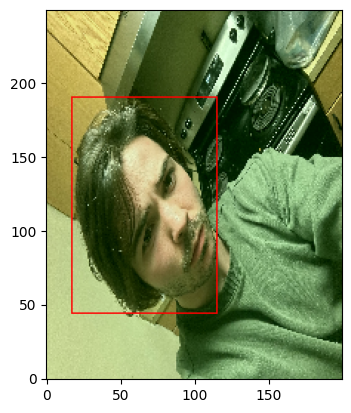

In [44]:
print(result_list[100][0]['boxes'].squeeze(dim=0))


print(len(result_list))


x,y = Test_Dataset.__getitem__(600)
print(type(y))
display_img_with_box(np.array(X_test[600]),result_list[600][0]['boxes'].tolist()[0])

# Save the model so we can use it anywhere!

In [45]:
torch.save(model.state_dict(), "Liam_Recognition_Faster_RCNN")